In [1]:
import xarray as xr
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter  # Custom labeling
import matplotlib.dates as mdates
import glob
import gc
import os.path

## Try Map Blocks

In [8]:
def demarcate_blooms(x):
    
    # Exit function if more than 6 months with no data
    
    mon_count = x.resample(time='M', skipna=True).count()
    if (mon_count>0).sum() < 270:
        return (xr.zeros_like(x))
        
    else:

        # Interpolate missing data
        x = x.interpolate_na(dim='time', method="linear")
        x = x.rolling(time=14, center=True).mean()

        bloom_criteria = x.mean() 
        bloom_criteria = bloom_criteria + np.abs(bloom_criteria) * 0.05
        
        # Array with values of 1 when chl > bloom criteria, otherwise 0
        bloom_events = xr.zeros_like(x)
        bloom_events = bloom_events.where(x > bloom_criteria, 1)
        
        # Now take the cumulative sum of 1s and 0s.
        bloom_events = bloom_events.cumsum() + 1

        ## Get climatolgical bloom start (bs_clim) and end (bt_clim)
        clim= x.groupby('time.dayofyear').mean()
        clim = np.array(np.concatenate((clim.values, clim.values), axis=None))

        clim_blooms = xr.DataArray(
            data= np.where(clim >= bloom_criteria.values, 1, 0),
            dims=["time"],
            coords=dict(time=range(732)))

        clim_blooms_yr = clim_blooms.cumsum(dim='time') - clim_blooms.cumsum(dim='time').where(clim_blooms.values == 0).ffill(dim='time').fillna(0)
        bt_clim = clim_blooms_yr.idxmax(dim='time').values 
        if bt_clim > 365:
            bt_clim = bt_clim - 365
        bs_clim = bt_clim - clim_blooms_yr.argmax(dim='time').values
        if bs_clim < 0:
            bs_clim = 31


        # Bloom Events_yr = 1 otherwise 0. Reset index at beginning of year
        bloom_events_yr = xr.zeros_like(x)
        bloom_events_yr = bloom_events_yr.where(x < bloom_criteria, 1)
        bloom_events_yr = xr.where(x.time.dt.dayofyear>(bt_clim+30), 0, bloom_events_yr)
        bloom_events_yr = xr.where(x.time.dt.dayofyear<(bs_clim-30), 0, bloom_events_yr)
        bloom_events_yr = bloom_events_yr * np.abs(x)
        bloom_events_yr = bloom_events_yr.cumsum(dim='time') - bloom_events_yr.cumsum(dim='time').where(bloom_events_yr.values == 0).ffill(dim='time').fillna(0)

        bt = bloom_events_yr.groupby('time.year').apply(lambda c: c.idxmax(dim="time")) 

        primary_blooms = bloom_events.sel(time=bt)
        primary_blooms_events = xr.zeros_like(x)
        for foo in primary_blooms.values:
            primary_blooms_events = xr.where(bloom_events == foo, 1, primary_blooms_events)
        cumulative =  primary_blooms_events.cumsum(dim='time') - primary_blooms_events.cumsum(dim='time').where(primary_blooms_events.values == 0).ffill(dim='time').fillna(0)
        return (cumulative)




In [9]:
infiles = glob.glob('/media/gsilsbe/modis/occci/v5/regrid/chl_log2/*.nc')
outfiles = [string.replace('/media/gsilsbe/modis/occci/v5/regrid/chl_log2/', '') for string in infiles]
outfiles = [string.replace('.nc', '') for string in outfiles]
outfiles

['g_20N_29W']

In [ ]:
for i,j in zip(infiles, outfiles):
    ds =  xr.open_dataset(i)['chlor_a'].stack(z=('lat', 'lon'))
    if ds.count().values >0 and os.path.exists('/media/gsilsbe/modis/occci/v5/phenology/bd/' + j  + '.nc') == False:
        data = ds.chunk({'time': -1, 'z':1})
        res = data.map_blocks(demarcate_blooms, template=data)

        bd = res.groupby('time.year').apply(lambda c: c.max(dim="time"))
        be = res.groupby('time.year').apply(lambda c: c.argmax(dim="time"))
        bi = be - bd

        bd.unstack('z').to_netcdf('/media/gsilsbe/modis/occci/v5/phenology/bd/' + j  + '.nc') 
        be.unstack('z').to_netcdf('/media/gsilsbe/modis/occci/v5/phenology/be/' + j  + '.nc')
        bi.unstack('z').to_netcdf('/media/gsilsbe/modis/occci/v5/phenology/bi/' + j  + '.nc')
        
        del data
        del res
        del be
        del bi
        del bd    
        del ds
        gc.collect()


In [ ]:
import time

ds =  xr.open_dataset('/media/gsilsbe/modis/occci/v5/regrid/chl_log2/g_40N_29W.nc')['chlor_a'].stack(z=('lat', 'lon')).chunk({'time': -1, 'z':1})

start_time = time.time()
res = ds.map_blocks(demarcate_blooms, template=ds).compute()
print('minutes ', (time.time() - start_time) / 60 )

res = res.unstack('z')
res.to_netcdf('res_40N_29W.nc')
res

bd = res.groupby('time.year').apply(lambda c: c.max(dim="time"))
be = res.groupby('time.year').apply(lambda c: c.argmax(dim="time"))
bi = be - bd

bi.plot(col='year', vmin=50, vmax=250, col_wrap=5)

### Map primary blooms in time

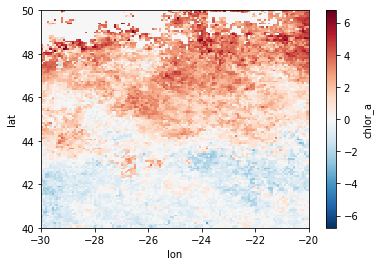

In [69]:
from scipy import stats

# https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset

def new_linregress(bloom_date):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(range(23), bloom_date)
    return np.array([slope, intercept, r_value, p_value, std_err])  #

be_stats = xr.apply_ufunc(new_linregress, be,
                          input_core_dims=[['year']],
                          output_core_dims=[["stats"]],
                          vectorize=True,
                          dask="parallelized",
                          output_dtypes=['float64'])

be_stats.isel(stats=0).plot()



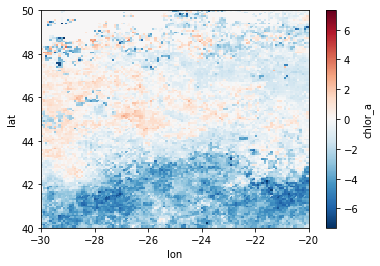

In [72]:
bd_stats = xr.apply_ufunc(new_linregress, bi,
                          input_core_dims=[['year']],
                          output_core_dims=[["stats"]],
                          vectorize=True,
                          dask="parallelized",
                          output_dtypes=['float64'])

bd_stats.isel(stats=0).plot()

In [ ]:
#foo = xr.open_dataset('/media/gsilsbe/LaCie/occci/v5/phenology/bi/g1_13.nc')
#foo.chlor_a.plot(x='lon', y='lat', col='year', col_wrap=3)

In [ ]:
#foo = xr.open_dataset('/media/gsilsbe/LaCie/occci/v5/regrid/chl_log2/small/g1_7.nc').isel(time=1405)
#foo.chlor_a.plot()

In [ ]:
#foo = xr.open_dataset('/media/gsilsbe/LaCie/occci/v5/regrid/chl_log2/small/g1_7.nc')['chlor_a'].stack(z=('lat', 'lon'))
#data = ds.chunk({'time': -1, 'z':1})